In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, SVR
from sklearn import datasets
from sklearn.metrics import confusion_matrix, accuracy_score
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader 
import copy

import xgboost as xgb
import lightgbm as lgbm
import catboost as cbt
from sklearn_rvm import EMRVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from datetime import datetime
from sklearn.svm import OneClassSVM
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest 
from sklearn.neighbors import LocalOutlierFactor

c:\venv_python_3.10\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 🌊 Anomaly Detection for Regression2Classification Task

- Anoamly Detection은 근본적인 Regression을 Anoamly Detection으로 변경한 Task에여대하여 Anomaly Detection이 가능할까?

# Load Dataset

In [190]:
# random_seed
# rand_seed = 1024 
rand_seed = 2048 
# rand_seed = 4096

# Select Dataset

dataset_name = 'diabetes_r'
# dataset_name = 'boston_r'

if dataset_name == 'diabetes_r':
    X, y= datasets.load_diabetes(return_X_y=True)
    threshold_anomaly = 140 # min 25, median 140.5, max 346
    THRESHOLD_FOR_RECONSTRUCTION = 1.00
    THRESHOLD_FOR_DENSITY = 43 
    NUM_1ST_HIDDEN = 6 
    NUM_2ND_HIDDEN = 3 

    # df = pd.read_csv('diabetes.csv')
    # X = df.iloc[:,:-1].values   
    # y = df.iloc[:,-1].values    
elif dataset_name == 'boston_r':
    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    y = raw_df.values[1::2, 2]

    threshold_anomaly = 21 # max 50, median 21.2, min 5 
    THRESHOLD_FOR_RECONSTRUCTION = 0.95
    THRESHOLD_FOR_DENSITY = 76
    NUM_1ST_HIDDEN = 5 
    NUM_2ND_HIDDEN = 2 
else:
    pass

In [191]:
print(f'Median {np.median(y)}')
print(f'Min {np.min(y)}')
print(f'Max {np.max(y)}')

Median 140.5
Min 25.0
Max 346.0


# Split data by specific threshold
- To convert regression problem to classification problem (two class for anomaly detection)

In [192]:
print("X shape")
print(X.shape)
print("Y shape")
print(y.shape)

X shape
(442, 10)
Y shape
(442,)


In [193]:
# split the dataset
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=rand_seed, train_size=0.8)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, random_state=rand_seed, train_size=0.8)



In [194]:
y_train_c = y_train.copy()
y_valid_c = y_valid.copy()
y_test_c = y_test.copy()

y_train_c[y_train>threshold_anomaly] = -1
y_train_c[y_train<=threshold_anomaly] = 1

y_valid_c[y_valid>threshold_anomaly] = -1
y_valid_c[y_valid<=threshold_anomaly] = 1

y_test_c[y_test>threshold_anomaly] = -1
y_test_c[y_test<=threshold_anomaly] = 1

In [195]:
# scaling by minmax scaler
scaler = MinMaxScaler()

scaler = scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_valid = scaler.transform(x_valid)

In [196]:
print('valid', len(y_valid_c[y_valid_c==-1]))
print('train', len(y_train_c[y_train_c ==-1]))
print('test', len(y_test_c[y_test_c ==-1]))

print('len train origin : ', len(x_train))
x_train_only = x_train[y_train_c==1]
print('len train origin with only true : ', len(x_train_only))

valid 36
train 140
test 45
len train origin :  282
len train origin with only true :  142


# SVR (Support Vector Regression)
- Classification using Regression

In [197]:
param_grid = [
    {'kernel': ['linear'], 'C': [1.0, 2.0, 3.0, 10., 30., 100.]},
    {'kernel': ['rbf'], 'C': [1.0, 2.0, 3.0, 5.0, 10., 30., 100.],
    'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
]

elapsed_time_kernel_svr = []

svr_regressor = SVR(kernel='rbf')
# svm_classifier = svm_classifier.fit(x_train, y_train)

start_time = datetime.now()
grid_search = GridSearchCV(svr_regressor, param_grid, cv=7, scoring="neg_mean_squared_error", verbose=2)
best_svr_regressor = grid_search.fit(x_train, y_train)
elapsed_time_kernel_svr.append((datetime.now()-start_time).total_seconds())



Fitting 7 folds for each of 48 candidates, totalling 336 fits
[CV] END ...............................C=1.0, kernel=linear; total time=   0.0s
[CV] END ...............................C=1.0, kernel=linear; total time=   0.0s
[CV] END ...............................C=1.0, kernel=linear; total time=   0.0s
[CV] END ...............................C=1.0, kernel=linear; total time=   0.0s
[CV] END ...............................C=1.0, kernel=linear; total time=   0.0s
[CV] END ...............................C=1.0, kernel=linear; total time=   0.0s
[CV] END ...............................C=1.0, kernel=linear; total time=   0.0s
[CV] END ...............................C=2.0, kernel=linear; total time=   0.0s
[CV] END ...............................C=2.0, kernel=linear; total time=   0.0s
[CV] END ...............................C=2.0, kernel=linear; total time=   0.0s
[CV] END ...............................C=2.0, kernel=linear; total time=   0.0s
[CV] END ...............................C=2.0, 

In [198]:

# y_pred = svm_classifier.predict(x_test)
start_time = datetime.now()
y_pred = best_svr_regressor.predict(x_test)
elapsed_time_kernel_svr.append((datetime.now()-start_time).total_seconds())



In [199]:
# print(np.argwhere(y_test > 300))

# print(np.argwhere(y_pred > 250))
print(y_test)

[134. 272. 104. 111. 132.  57.  87. 153. 140. 135. 164. 101. 151.  42.
 167.  80. 257. 102. 147.  47. 206. 170. 182. 185. 270. 187. 128. 236.
 191.  54.  95. 152. 129.  96.  92.  98.  97. 200. 173. 116. 198. 128.
 225. 163. 214. 163.  55. 230. 103. 104. 195. 160. 108. 216. 100. 150.
 126. 122.  77. 131. 270. 200.  84. 233.  53. 202.  69. 101. 198. 252.
  64. 263.  94. 178. 293. 121. 102. 276.  31.  37. 229. 219.  71. 174.
 111. 164. 200. 259. 197.]


In [200]:
print(y_pred)

[130.77687884 230.06979146 167.67701776  99.55027363 129.46873952
  44.121605   100.26217293 110.98057487 181.74944854 129.15934281
 182.91733877  74.71748256 189.26588431  94.05704235 180.83482928
 102.16310116 189.65222454 110.27012347 160.67094114  59.07613999
 154.12377888  85.83645526 133.58978843 126.30947    285.87277994
 117.12440128 214.47548083 221.84836127 116.61847793  79.71572607
 145.37973784  98.15086468 143.94892499  56.14464056  80.61042708
  86.72165598 100.63522311  87.72058434 218.84749633  44.12105746
 199.964844    97.76506308 226.31351356 178.94581067 131.6886538
 210.21803209  55.37827918 307.93454885 120.36427832 106.477673
 220.23293725 107.22283911 112.00932371 170.92491152 165.76593548
 144.50972518 148.61114598 171.24880332  81.06430197 181.60905922
 236.89028541 178.57915858  90.98372421 201.94331775  82.99452459
 175.60226535 119.32844139 107.13519348 163.30876321 150.38572439
  91.45849919 181.06184043  70.92689633 174.07985688 190.50015135
 155.0646952 

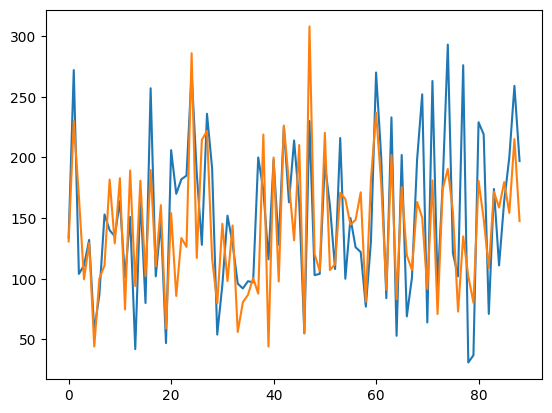

In [201]:
x = np.arange(0, len(y_test))
plt.plot(x, y_test)
plt.plot(x, y_pred)
plt.show()

In [202]:
y_pred_c = y_pred.copy()
y_pred_c[y_pred > threshold_anomaly] = -1
y_pred_c[y_pred <= threshold_anomaly] = 1

print(y_pred_c)

[ 1. -1. -1.  1.  1.  1.  1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1.
 -1.  1. -1.  1.  1.  1. -1.  1. -1. -1.  1.  1. -1.  1. -1.  1.  1.  1.
  1.  1. -1.  1. -1.  1. -1. -1.  1. -1.  1. -1.  1.  1. -1.  1.  1. -1.
 -1. -1. -1. -1.  1. -1. -1. -1.  1. -1.  1. -1.  1.  1. -1. -1.  1. -1.
  1. -1. -1. -1.  1.  1.  1.  1. -1. -1.  1. -1. -1. -1. -1. -1. -1.]


In [203]:
acc_svr_kernel = accuracy_score(y_test_c, y_pred_c)

In [204]:
print('Confusion Matrix\n', confusion_matrix(y_test_c, y_pred_c))
print('Best Prameters ', grid_search.best_params_)
print('Accuracy ', acc_svr_kernel)
print('Elapsed Time(train, test) ', elapsed_time_kernel_svr)

Confusion Matrix
 [[34 11]
 [11 33]]
Best Prameters  {'C': 100.0, 'gamma': 0.1, 'kernel': 'rbf'}
Accuracy  0.7528089887640449
Elapsed Time(train, test)  [0.928411, 0.002007]


# One-Class SVM - Linear & Kernel

In [224]:
param_grid = [
    {'kernel': ['linear'], 'nu': [0.05, 0.1, 0.25, 0,5, 0.7]},
    {'kernel': ['rbf'], 'nu': [0.05, 0.1, 0.25, 0,5, 0.7],
    'gamma': [0.01, 0.03, 0.1, 0.3, 0.05, 1.0]},
]

elapsed_time_kernel_svm = []

svm_classifier = OneClassSVM(kernel='rbf')
# svm_classifier = svm_classifier.fit(x_train, y_train)

start_time = datetime.now()
grid_search = GridSearchCV(svm_classifier, param_grid, cv=7, scoring="neg_mean_squared_error", verbose=2)
best_svm_classifier = grid_search.fit(x_train_only)
elapsed_time_kernel_svm.append((datetime.now()-start_time).total_seconds())


start_time = datetime.now()
y_pred = best_svm_classifier.predict(x_test)
elapsed_time_kernel_svm.append((datetime.now()-start_time).total_seconds())
acc_svm_kernel = accuracy_score(y_test_c, y_pred)



Fitting 7 folds for each of 42 candidates, totalling 294 fits
[CV] END .............................kernel=linear, nu=0.05; total time=   0.0s
[CV] END .............................kernel=linear, nu=0.05; total time=   0.0s
[CV] END .............................kernel=linear, nu=0.05; total time=   0.0s
[CV] END .............................kernel=linear, nu=0.05; total time=   0.0s
[CV] END .............................kernel=linear, nu=0.05; total time=   0.0s
[CV] END .............................kernel=linear, nu=0.05; total time=   0.0s
[CV] END .............................kernel=linear, nu=0.05; total time=   0.0s
[CV] END ..............................kernel=linear, nu=0.1; total time=   0.0s
[CV] END ..............................kernel=linear, nu=0.1; total time=   0.0s
[CV] END ..............................kernel=linear, nu=0.1; total time=   0.0s
[CV] END ..............................kernel=linear, nu=0.1; total time=   0.0s
[CV] END ..............................kernel=l

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

In [225]:
print('Confusion Matrix\n', confusion_matrix(y_test_c, y_pred))
print('Best Prameters ', grid_search.best_params_)
print('Accuracy ', acc_svm_kernel)
print('Elapsed Time(train, test) ', elapsed_time_kernel_svm)
# Isolation Forest 

Confusion Matrix
 [[ 2 43]
 [ 3 41]]
Best Prameters  {'kernel': 'linear', 'nu': 0.05}
Accuracy  0.48314606741573035
Elapsed Time(train, test)  [0.198354, 0.0]


# Isolation Forest

In [226]:
iforest_classifier = IsolationForest()

# iforest_parameters ={'contamination' : [0.01, 0.04, 0.08, 0.12, 0.16] , 'n_estimators': [4, 8, 12,24,32, 64]}

iforest_parameters = {'n_estimators': list(range(10, 200, 50)), 
              'max_samples': list(range(20, 120, 20)), 
              'contamination': [0.1, 0.2], 
              'max_features': [5,15, 20], 
              'bootstrap': [True, False], 
              }



#  'learning_rate' : [0.01,0.02,0.03],
#  'gamma': [0.5, 1, 2], 'random_state':[99]}
elapsed_time_iforest = []

start_time = datetime.now()
iforest_grid_search = GridSearchCV(iforest_classifier, iforest_parameters, cv=7, scoring="neg_mean_squared_error", verbose=2)
best_iforest_classifier = iforest_grid_search.fit(x_train_only)
elapsed_time_iforest.append((datetime.now()-start_time).total_seconds())

Fitting 7 folds for each of 240 candidates, totalling 1680 fits
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=60; total time

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=60; total time

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=60; total time

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=60; to

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=160; total time=   0.1s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=15, max_samples=20, n_estimators=60; t

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=60; total time

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=60; total time

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=60; total time

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=60; to

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=15, max_samples=20, n_estimators=60; t

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=60; t

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=10; 

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=60; t

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimato

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=15, max_samples=20, n_estimat

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=60; t

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=10; 

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=160; total time=   0.1s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=60; t

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=160; total time=   0.1s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimato

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=15, max_samples=20, n_estim

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
1120 fits failed out of a total of 1680.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1120 fits failed with the following error:
Traceback (most recent call las

In [227]:
# y_pred = xgb_classifier.predict(x_test)
start_time = datetime.now()
y_pred_c = best_iforest_classifier.predict(x_test)
elapsed_time_iforest.append((datetime.now()-start_time).total_seconds())


acc_iforest = accuracy_score(y_test_c, y_pred_c)

print('Confusion Matrix\n', confusion_matrix(y_test_c, y_pred_c))
print("best parameters ", iforest_grid_search.best_params_)
print('Accuracy ', acc_iforest)
print('elapsed time ', elapsed_time_iforest)

Confusion Matrix
 [[13 32]
 [ 3 41]]
best parameters  {'bootstrap': True, 'contamination': 0.1, 'max_features': 5, 'max_samples': 20, 'n_estimators': 10}
Accuracy  0.6067415730337079
elapsed time  [43.155636, 0.003565]


# Autoencoder for Anomaly Detection

In [228]:
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)



class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

train_data = TrainData(torch.FloatTensor(x_train_only), 
                       torch.FloatTensor(x_train_only))

test_data = TestData(torch.FloatTensor(x_test))
valid_data = TrainData(torch.FloatTensor(x_valid), torch.FloatTensor(x_valid))

train_loader = DataLoader(dataset=train_data, batch_size=8, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)
valid_loader = DataLoader(dataset=valid_data, batch_size=2)

In [229]:
EPOCHS = 500 
BATCH_SIZE = 128 
LEARNING_RATE = 0.01

NUM_INPUT = x_train.shape[1]
NUM_OUTPUT = x_train.shape[1] 
NUM_1ST_DROPOUT = 0.2
NUM_2ND_DROPOUT = 0.1
NUM_3RD_DROPOUT = 0.1

In [230]:
NUM_1ST_HIDDEN

6

In [231]:
class BasicClassification(nn.Module):
    def __init__(self) -> None:
        super(BasicClassification, self).__init__()

        self.layer_1 = nn.Linear(NUM_INPUT, NUM_1ST_HIDDEN)
        self.layer_2 = nn.Linear(NUM_1ST_HIDDEN, NUM_2ND_HIDDEN)
        self.layer_3 = nn.Linear(NUM_2ND_HIDDEN, NUM_1ST_HIDDEN)
        self.layer_4 = nn.Linear(NUM_1ST_HIDDEN, NUM_INPUT)

        # self.actvation = nn.ReLU()
        self.actvation_1 = nn.SELU()
        self.actvation_2 = nn.SELU()
        self.actvation_3 = nn.SELU()

        # self.actvation_1 = nn.ReLU()
        # self.actvation_2 = nn.ReLU()
        # self.actvation_3 = nn.ReLU()

        self.dropout_1 = nn.Dropout(p=NUM_1ST_DROPOUT)
        self.dropout_2 = nn.Dropout(p=NUM_2ND_DROPOUT)
        self.dropout_3 = nn.Dropout(p=NUM_3RD_DROPOUT)
        self.batchnorm_1 = nn.BatchNorm1d(NUM_1ST_HIDDEN)
        self.batchnorm_2 = nn.BatchNorm1d(NUM_2ND_HIDDEN)
        self.batchnorm_3 = nn.BatchNorm1d(NUM_1ST_HIDDEN)
    
    def forward(self, inputs):
        x = self.actvation_1(self.layer_1(inputs))
        # x = self.batchnorm_1(x)
        # x = self.dropout_1(x)
        x = self.actvation_2(self.layer_2(x))
        # x = self.batchnorm_2(x)
        # x = self.dropout_2(x)

        x = self.actvation_3(self.layer_3(x))
        # x = self.batchnorm_3(x)
        # x = self.dropout_3(x)

        # x = self.actvation_4(self.layer_4(x))
        # x = self.batchnorm_3(x)
        # x = self.dropout_3(x)


        x = self.layer_4(x)

        return x
        
# class BasicClassification(nn.Module):
#     def __init__(self) -> None:
#         super(BasicClassification, self).__init__()

#         self.layer_1 = nn.Linear(NUM_INPUT, NUM_1ST_HIDDEN)
#         self.layer_2 = nn.Linear(NUM_1ST_HIDDEN, NUM_2ND_HIDDEN)
#         self.layer_3 = nn.Linear(NUM_2ND_HIDDEN, NUM_1ST_HIDDEN)
#         self.layer_4 = nn.Linear(NUM_1ST_HIDDEN, NUM_INPUT)

#         # self.actvation = nn.ReLU()
#         self.actvation_1 = nn.SELU()
#         self.actvation_2 = nn.SELU()
#         self.actvation_3 = nn.SELU()
#         self.dropout_1 = nn.Dropout(p=NUM_1ST_DROPOUT)
#         self.dropout_2 = nn.Dropout(p=NUM_2ND_DROPOUT)
#         self.dropout_3 = nn.Dropout(p=NUM_3RD_DROPOUT)
#         self.batchnorm_1 = nn.BatchNorm1d(NUM_1ST_HIDDEN)
#         self.batchnorm_2 = nn.BatchNorm1d(NUM_2ND_HIDDEN)
#         self.batchnorm_3 = nn.BatchNorm1d(NUM_1ST_HIDDEN)
    
#     def forward(self, inputs):
#         x = self.actvation_1(self.layer_1(inputs))
#         x = self.batchnorm_1(x)
#         x = self.dropout_1(x)
#         x = self.actvation_2(self.layer_2(x))
#         x = self.batchnorm_2(x)
#         x = self.dropout_2(x)

#         x = self.actvation_3(self.layer_3(x))
#         x = self.batchnorm_3(x)
#         x = self.dropout_3(x)

#         # x = self.actvation_4(self.layer_4(x))
#         # x = self.batchnorm_3(x)
#         # x = self.dropout_3(x)


#         x = self.layer_4(x)

#         return x


In [232]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [233]:
model = BasicClassification()
model.to(device)

print(model)


# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

BasicClassification(
  (layer_1): Linear(in_features=10, out_features=6, bias=True)
  (layer_2): Linear(in_features=6, out_features=3, bias=True)
  (layer_3): Linear(in_features=3, out_features=6, bias=True)
  (layer_4): Linear(in_features=6, out_features=10, bias=True)
  (actvation_1): SELU()
  (actvation_2): SELU()
  (actvation_3): SELU()
  (dropout_1): Dropout(p=0.2, inplace=False)
  (dropout_2): Dropout(p=0.1, inplace=False)
  (dropout_3): Dropout(p=0.1, inplace=False)
  (batchnorm_1): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_2): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_3): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [234]:
best_model  = None
best_loss_on_valid = 999999999
num_train_data = len(train_loader)
num_eval_data = len(valid_loader)


elapsed_time_basic_ann = []

start_time = datetime.now()


for epoch in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0

    eval_epoch_loss = 0
    eval_epoch_acc = 0

    model.train()
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()

        y_pred = model(x_batch)

        loss = criterion(y_pred, y_batch)
        # acc = calc_accuracy(y_pred, y_batch)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        # epoch_acc += acc.item()
    
    if epoch % 10 == 0:
        
        with torch.no_grad():
            model.eval()
            for x, y in valid_loader:
                x = x.to(device)
                y = y.to(device)

                output = model(x)

                eval_loss = criterion(output, y)
                # eval_acc = calc_accuracy(output, y)

                eval_epoch_loss += eval_loss.item()
                # eval_epoch_acc += eval_acc.item()
        
        if best_loss_on_valid >= (eval_epoch_loss/num_eval_data):
            best_loss_on_valid = (eval_epoch_loss/num_eval_data)
            best_model = copy.deepcopy(model)
            print("Best Model is copied - Best Loss : ", best_loss_on_valid)
        


        print(f"Epoch {epoch+0:03}: : Loss: T_{epoch_loss/num_train_data:.3f} V_{eval_epoch_loss/num_eval_data:.3f} | Acc: T_{epoch_acc/num_train_data:.3f}) V_{eval_epoch_acc/num_eval_data:.3f}")


elapsed_time_basic_ann.append((datetime.now()-start_time).total_seconds())

Best Model is copied - Best Loss :  0.018315138954979677
Epoch 010: : Loss: T_0.016 V_0.018 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  0.015581104128311077
Epoch 020: : Loss: T_0.013 V_0.016 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  0.015113365616545908
Epoch 030: : Loss: T_0.012 V_0.015 | Acc: T_0.000) V_0.000
Epoch 040: : Loss: T_0.012 V_0.017 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  0.014528655744571652
Epoch 050: : Loss: T_0.012 V_0.015 | Acc: T_0.000) V_0.000
Epoch 060: : Loss: T_0.011 V_0.017 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  0.014302927289261587
Epoch 070: : Loss: T_0.011 V_0.014 | Acc: T_0.000) V_0.000
Epoch 080: : Loss: T_0.011 V_0.015 | Acc: T_0.000) V_0.000
Epoch 090: : Loss: T_0.011 V_0.014 | Acc: T_0.000) V_0.000
Epoch 100: : Loss: T_0.011 V_0.015 | Acc: T_0.000) V_0.000
Epoch 110: : Loss: T_0.011 V_0.014 | Acc: T_0.000) V_0.000
Epoch 120: : Loss: T_0.011 V_0.014 | Acc: T_0.000) V_0.000
Epoch 1

In [235]:

# with torch.no_grad():
# model.eval()
best_model.eval()
data = torch.from_numpy(x_test).float().to(device)
# answer = torch.from_numpy(y_test_onehot).float().to(device)


# data = torch.from_numpy(x_train).float().to(device)
# answer = torch.from_numpy(y_train_onehot).float().to(device)


# data = torch.from_numpy(x_valid).float().to(device)
# answer = torch.from_numpy(y_valid_onehot).float().to(device)

start_time = datetime.now()
output = best_model(data)
# acc_basic_ann = calc_accuracy(output, answer)
elapsed_time_basic_ann.append((datetime.now()-start_time).total_seconds())

# print('Accuracy ', acc_basic_ann)
print('elapsed time ', elapsed_time_basic_ann)

elapsed time  [30.342449, 0.001]


In [236]:

output_num = output.detach().cpu().numpy()



In [237]:
result_reconstruct = abs(x_test - output_num).sum(axis=1)

In [282]:
result_reconstruct

array([0.83022025, 1.60812472, 1.02816545, 0.58629247, 0.44878927,
       1.77926337, 0.67562142, 0.47169088, 1.3433489 , 0.74389531,
       0.61730863, 0.63110249, 1.06439855, 0.77775094, 1.01200418,
       0.85291289, 1.09433708, 1.00219231, 0.58157849, 0.81172995,
       0.18926641, 1.21480389, 1.36077249, 0.60471568, 1.70271346,
       0.66886662, 0.79423119, 1.14231723, 1.01240963, 0.68663444,
       0.88837777, 0.69936995, 0.61480061, 0.92683543, 1.09770368,
       0.44999801, 0.51001106, 0.57905178, 0.81969972, 0.52883816,
       0.68490083, 0.9414622 , 1.14554189, 0.82495296, 0.67444129,
       0.68604385, 0.81326634, 1.64746564, 0.88938461, 1.06918831,
       1.29363328, 0.59232746, 0.60850661, 1.34149716, 0.79760869,
       0.7993167 , 0.88864718, 0.31656242, 0.92429139, 0.78763773,
       1.52373924, 1.1725715 , 0.34948373, 1.22592073, 0.74987585,
       1.22371018, 1.51249087, 0.9188493 , 0.73854761, 1.58830881,
       1.03932913, 0.86761129, 0.88250332, 0.58062118, 1.27480

In [337]:

result_class = result_reconstruct.copy()
result_class[result_reconstruct > THRESHOLD_FOR_RECONSTRUCTION] = -1
result_class[result_reconstruct <=THRESHOLD_FOR_RECONSTRUCTION] = 1

# result_class
acc_ae = accuracy_score(y_test_c, result_class)

print('Confusion Matrix\n', confusion_matrix(y_test_c, result_class))
print('Accuracy ', acc_ae)

Confusion Matrix
 [[20 25]
 [ 9 35]]
Accuracy  0.6179775280898876


# Mixture of Gaussian

In [239]:
gmm_classifier = GaussianMixture()

# lgbm_classifier=lgbm_classifier.fit(x_train, y_train)
# y_pred = lgbm_classifier.predict(x_test)


gmm_parameters ={'n_components' : [1, 2, 3,4,5,6, 7] , 'max_iter': [int(1e2), int(1e3), int(1e6)]}
#  'learning_rate' : [0.01,0.02,0.03],
#  'gamma': [0.5, 1, 2], 'random_state':[99]}

elapsed_time_gmm= []

start_time = datetime.now()
gmm_grid_search = GridSearchCV(gmm_classifier, gmm_parameters, cv=7, scoring="neg_mean_squared_error", verbose=2)
best_gmm_classifier = gmm_grid_search.fit(x_train_only)
elapsed_time_gmm.append((datetime.now()-start_time).total_seconds())




# acc_lgbm = accuracy_score(y_test, y_pred)

# print('Confusion Matrix\n', confusion_matrix(y_test, y_pred))
# print("best parameters ", lgbm_grid_search.best_params_)
# print('Accuracy ', acc_lgbm)
# print('elapsed time ', elapsed_time_lgbm)


Fitting 7 folds for each of 21 candidates, totalling 147 fits
[CV] END .......................max_iter=100, n_components=1; total time=   0.0s
[CV] END .......................max_iter=100, n_components=1; total time=   0.0s
[CV] END .......................max_iter=100, n_components=1; total time=   0.0s
[CV] END .......................max_iter=100, n_components=1; total time=   0.0s
[CV] END .......................max_iter=100, n_components=1; total time=   0.0s
[CV] END .......................max_iter=100, n_components=1; total time=   0.0s
[CV] END .......................max_iter=100, n_components=1; total time=   0.0s
[CV] END .......................max_iter=100, n_components=2; total time=   0.0s
[CV] END .......................max_iter=100, n_components=2; total time=   0.0s
[CV] END .......................max_iter=100, n_components=2; total time=   0.0s
[CV] END .......................max_iter=100, n_components=2; total time=   0.0s
[CV] END .......................max_iter=100, n

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END .......................max_iter=100, n_components=4; total time=   0.0s
[CV] END .......................max_iter=100, n_components=4; total time=   0.0s
[CV] END .......................max_iter=100, n_components=4; total time=   0.0s
[CV] END .......................max_iter=100, n_components=4; total time=   0.0s
[CV] END .......................max_iter=100, n_components=5; total time=   0.0s
[CV] END .......................max_iter=100, n_components=5; total time=   0.0s
[CV] END .......................max_iter=100, n_components=5; total time=   0.0s
[CV] END .......................max_iter=100, n_components=5; total time=   0.0s
[CV] END .......................max_iter=100, n_components=5; total time=   0.0s
[CV] END .......................max_iter=100, n_components=5; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END .......................max_iter=100, n_components=5; total time=   0.0s
[CV] END .......................max_iter=100, n_components=6; total time=   0.0s
[CV] END .......................max_iter=100, n_components=6; total time=   0.0s
[CV] END .......................max_iter=100, n_components=6; total time=   0.0s
[CV] END .......................max_iter=100, n_components=6; total time=   0.0s
[CV] END .......................max_iter=100, n_components=6; total time=   0.0s
[CV] END .......................max_iter=100, n_components=6; total time=   0.0s
[CV] END .......................max_iter=100, n_components=6; total time=   0.0s
[CV] END .......................max_iter=100, n_components=7; total time=   0.0s
[CV] END .......................max_iter=100, n_components=7; total time=   0.0s
[CV] END .......................max_iter=100, n_components=7; total time=   0.0s
[CV] END .......................max_iter=100, n_components=7; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END .......................max_iter=100, n_components=7; total time=   0.0s
[CV] END .......................max_iter=100, n_components=7; total time=   0.0s
[CV] END .......................max_iter=100, n_components=7; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=1; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=1; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=1; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=1; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=1; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=1; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=1; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=2; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END ......................max_iter=1000, n_components=2; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=2; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=2; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=2; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=2; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=2; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=3; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=3; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=3; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=3; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=3; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=3; total time=   0.0s
[CV] END ...................

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END ......................max_iter=1000, n_components=4; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=4; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=4; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=5; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=5; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=5; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=5; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=5; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=5; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=5; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=6; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END ......................max_iter=1000, n_components=6; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=6; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=6; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=6; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=6; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=6; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=7; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=7; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=7; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=7; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=7; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END ......................max_iter=1000, n_components=7; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=7; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=1; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=1; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=1; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=1; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=1; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=1; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=1; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=2; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=2; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=2; total time=   0.0s
[CV] END ...................

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END ...................max_iter=1000000, n_components=4; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=4; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=4; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=4; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=4; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=4; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=5; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=5; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=5; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=5; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=5; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=5; total time=   0.0s
[CV] END ...................

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END ...................max_iter=1000000, n_components=6; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=6; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=6; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=6; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=6; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=7; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=7; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=7; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=7; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=7; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=7; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=7; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

In [240]:
start_time = datetime.now()
y_pred_c = best_gmm_classifier.predict(x_test)
elapsed_time_gmm.append((datetime.now()-start_time).total_seconds())

In [241]:
y_pred_c

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0], dtype=int64)

In [242]:
print(len(np.argwhere(y_test_c == -1)))

45


In [269]:
densities = best_gmm_classifier.score_samples(x_test)
density_threshold = np.percentile(densities, THRESHOLD_FOR_DENSITY)
anomalies = np.argwhere(densities < density_threshold)
print(len(anomalies))
# print(anomalies)

# print(density_threshold)
# print(len(anomalies))
# print(np.argwhere(y_test_c == -1))
real_anomaly = np.argwhere(y_test_c == -1)
# print(real_)

y_pred_anomalies = y_test_c.copy()
y_pred_anomalies[densities < density_threshold] = -1
y_pred_anomalies[densities >= density_threshold] = 1


acc_iforest = accuracy_score(y_test_c, y_pred_anomalies)

print('Confusion Matrix\n', confusion_matrix(y_test_c, y_pred_anomalies))
print("best parameters ", best_gmm_classifier.best_params_)
print('Accuracy ', acc_iforest)
print('elapsed time ', elapsed_time_gmm)

# accuracy_score(y_test_c, y_pred_anomalies)

38
Confusion Matrix
 [[24 21]
 [14 30]]
best parameters  {'max_iter': 100, 'n_components': 1}
Accuracy  0.6067415730337079
elapsed time  [2.106531, 0.001001]


In [187]:
# y_pred_anomalies

# FINISHED